In [1]:
import os
import cv2

import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

# The cross-entropy loss penalizes the model more when it is more confident in the incorrect class
from torch.nn import CrossEntropyLoss

# Adam is an optimization algorithm that can be used instead of the classical SGD procedure
# to update network weights iterative based in training data.
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader, random_split

from torchvision import transforms
from torchvision.io import read_image

from torchinfo import summary

# np.random.seed(0)
# torch.manual_seed(0)

In [2]:
%load_ext cudf.pandas

/home/osmahus/pytVenv/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:61: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 254, in ensure_initialized
    self.cuInit(0)
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 327, in safe_cuda_api_call
    self._check_ctypes_error(fname, retcode)
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 395, in _check_ctypes_error
    raise CudaAPIError(retcode, msg)
numba.cuda.cudadrv.driver.CudaAPIError: [100] Call to cuInit results in CUDA_ERROR_NO_DEVICE

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/home/osmahus/pytVenv/lib/python3.11/site-packages/numba/cuda/cudadrv/driver.py", line 292, i

In [3]:
# torch.cuda.current_device()
# torch.cuda.get_device_name(0)
# torch.cuda.device_count()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Torch is using device:', device)
torch.cuda.get_device_name(device)

Torch is using device: cuda:0


'NVIDIA GeForce RTX 3070 Ti Laptop GPU'

In [4]:
path_tr = '../../data/CIFAK/train'
path_val = '../../data/CIFAK/test'

#### Remove Spaces from the Dataset folder to simplify reading from it

In [5]:
# def remove_fname_space(path):
#     for filename in os.listdir(path):
#         my_source = path + "/" + filename
#         my_dest = path + "/" + filename.strip().replace(" ", "")
#         os.rename(my_source, my_dest)

# remove_fname_space(path_tr + "/REAL")
# remove_fname_space(path_tr + "/FAKE")
# remove_fname_space(path_val + "/REAL")
# remove_fname_space(path_val + "/FAKE")

#### Gather all the data from the "CIFAK" dataset to be used later

In [6]:
def dataset_data(img_path, folder_name, img_class):
    fname = os.listdir(img_path + "/"+folder_name)
    fname.sort()
    fpath = [img_path + "/"+folder_name+"/" + f for f in fname]
    labels = [img_class]*len(fname)
    return fpath, labels

In [7]:
fpath_tr_real, labels_tr_real = dataset_data(path_tr, "REAL", 1.0)
fpath_tr_fake, labels_tr_fake = dataset_data(path_tr, "FAKE", 0.0)
fpath_tr = fpath_tr_real + fpath_tr_fake
labels_tr = labels_tr_real+labels_tr_fake
tr_dict = {'Image_path': fpath_tr, 'True?': labels_tr}
tr_df = pd.DataFrame(tr_dict)
tr_df.to_csv(path_tr+"/tr_annotation.csv")

fpath_val_real, labels_val_real = dataset_data(path_val, "REAL", 1.0)
fpath_val_fake, labels_val_fake = dataset_data(path_val, "FAKE", 0.0)
fpath_val = fpath_val_real + fpath_val_fake
labels_val = labels_val_real+labels_val_fake
val_dict = {'Image_path': fpath_val, 'True?': labels_val}
val_df = pd.DataFrame(val_dict)
val_df.to_csv(path_val+"/val_annotation.csv")

print("")
print("Total Number of:          Real         Fake         Total")
print("------------------------------------------------------------")
print("Training Samples:        ",len(fpath_tr_real),"     ",len(fpath_tr_fake),"       ",len(fpath_tr))
print("Validation Samples:      ",len(fpath_val_real),"     ",len(fpath_val_fake),"       ",len(fpath_val))


Total Number of:          Real         Fake         Total
------------------------------------------------------------
Training Samples:         50000       50000         100000
Validation Samples:       10000       10000         20000


In [8]:
validation,test=train_test_split(val_df,test_size=0.1,stratify=val_df[['True?']])
validation
test

,Image_path,True?
8941,../../data/CIFAK/test/REAL/0894(2).jpg,1.0
4209,../../data/CIFAK/test/REAL/0420.jpg,1.0
8230,../../data/CIFAK/test/REAL/0823(10).jpg,1.0
19686,../../data/CIFAK/test/FAKE/970(7).jpg,0.0
17465,../../data/CIFAK/test/FAKE/770(6).jpg,0.0
...,...,...
7035,../../data/CIFAK/test/REAL/0703(6).jpg,1.0
522,../../data/CIFAK/test/REAL/0052(3).jpg,1.0
19237,../../data/CIFAK/test/FAKE/93(8).jpg,0.0
6218,../../data/CIFAK/test/REAL/0621(9).jpg,1.0


In [9]:
print("tr_df")
tr_df.iloc[[0,1,99998,99999]]

tr_df


,Image_path,True?
0,../../data/CIFAK/train/REAL/0000(10).jpg,1.0
1,../../data/CIFAK/train/REAL/0000(2).jpg,1.0
99998,../../data/CIFAK/train/FAKE/5999(9).jpg,0.0
99999,../../data/CIFAK/train/FAKE/5999.jpg,0.0


In [10]:
print("val_df")
val_df.iloc[[0,1,19998,19999]]

val_df


,Image_path,True?
0,../../data/CIFAK/test/REAL/0000(10).jpg,1.0
1,../../data/CIFAK/test/REAL/0000(2).jpg,1.0
19998,../../data/CIFAK/test/FAKE/999(9).jpg,0.0
19999,../../data/CIFAK/test/FAKE/999.jpg,0.0


#### Determine the number of slices (patches) of the image

In [11]:
Img_horizontal_slices= 4
images_batch = 16

In [31]:
16*6250


100000

In [12]:
img_shape = cv2.imread(fpath_tr[0]).shape
print("Image Shape: ",img_shape)

slice_width = img_shape[0]//Img_horizontal_slices
print("Image Slice Shape: ",(slice_width,slice_width))

total_img_slices = Img_horizontal_slices**2
print("Total Number of Slices per Image: ",total_img_slices)
print("Total Number of Images per Loader: ",images_batch)


Image Shape:  (32, 32, 3)
Image Slice Shape:  (8, 8)
Total Number of Slices per Image:  16
Total Number of Images per Loader:  16


In [13]:
class SliceImage:
    def __init__(self, slice_width):
        self.slice_width = slice_width

    def slice(self, img):
        # img: is a tensor of the shape (Color_Channels x Rows (Hight) x Columns (Width))
        #
        # Make a slice every "slice_width" as we are moving across dimension 1 (as we are moving
        # vertically across rows)
        img = img.unfold(1, self.slice_width, self.slice_width)
        # Make a slice every slice_width as we are moving across dimension 2,
        # Note that previous operation has added new dimension at the beginning
        # refers to no. of vertical slices, hence 2 here still refers to the rows.
        img = img.unfold(2, self.slice_width, self.slice_width)
        return img

    def __call__(self, img):
        img = self.slice(img)
        channels = img.size(0)

        return img.reshape(-1, self.slice_width * self.slice_width * channels)

    plt.show()

In [14]:
# Define the transforms on the input data (x) tensor
data_transform = transforms.Compose([
    transforms.ToPILImage(),
    # transforms.Resize((32, 32)),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
    SliceImage(slice_width=slice_width)
])

In [15]:
# Custom Dataset Class
class Images_Dataset(Dataset):
    def __init__(self, annotations_file, transform=None):
        
        self.annotation = pd.read_csv(annotations_file)
        self.transform = transform

    def __getitem__(self, index):
        
        img = read_image(self.annotation.iloc[index, 1])

        labels = torch.tensor(self.annotation.iloc[index, 2])

        if self.transform:
            img_t = self.transform(img)

        return img, img_t, labels

    def __len__(self):
        # To return the length of the dataset
        return self.annotation.shape[0]

In [16]:
# Define the dataset object and configure the Data Loader
tr_annotation_file = path_tr+"/tr_annotation.csv"
val_annotation_file = path_val+"/val_annotation.csv"

Im_tr_dataset = Images_Dataset(tr_annotation_file, data_transform)

Im_tr_loader = DataLoader(dataset=Im_tr_dataset,
                          batch_size=images_batch,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          num_workers=4)


Im_val_dataset = Images_Dataset(val_annotation_file, data_transform)

Im_val_loader = DataLoader(dataset=Im_val_dataset,
                          batch_size=images_batch,
                          # Drops the last mini batch if less than the batch size (could enhance the model accuracy)
                          drop_last=True,
                          shuffle=True,
                          num_workers=4)

In [17]:
validation_split= int(np.round(len(Im_val_dataset)*0.8))
test_split= len(Im_val_dataset)-validation_split
print(validation_split)
print(test_split)
# validation_dataset, test_dataset = random_split(Im_val_dataset, [, val_size])

16000
4000


#### Plot the original Image and the slices Image

In [18]:
def img_data(Img_train_loader, index):

    date_sample=Img_train_loader.dataset[index]

    img = date_sample[0]
    img_t = date_sample[1]
    label = date_sample[2]

    channels = img.size(0)
    img_size = img.size(1)

    total_img_slices = img_t.size(0)
    slice_flat = img_t.size(1)

    imgs_per_batch = Im_tr_loader.batch_size

    slice_width = int(np.sqrt(slice_flat/channels))

    return img, channels, img_size, slice_width, total_img_slices, slice_flat, imgs_per_batch, label

In [19]:
def img_plot(img, slice_width):
    slice = SliceImage(slice_width)
    sliced_img = slice.slice(img).permute(1, 2, 0, 3, 4)

    fig = plt.figure(layout="constrained", figsize=(4, 4))
    subfigs = fig.subfigures(2, 1, height_ratios=[1., 1.])

    axs0 = subfigs[0].subplots(1, 1)
    axs0.imshow(img.permute(1, 2, 0))
    axs0.axis('off')

    grid = ImageGrid(subfigs[1], 111, nrows_ncols=(
        sliced_img.size(0), sliced_img.size(1)), axes_pad=0.03)

    for i, ax in enumerate(grid):
        i_b4 = str(np.base_repr(i, sliced_img.size(0))).zfill(2)
        row = int(i_b4[0])
        column = int(i_b4[1])
        patch = sliced_img[row][column].permute(1, 2, 0).numpy()
        ax.imshow(patch)
        ax.axis('off')

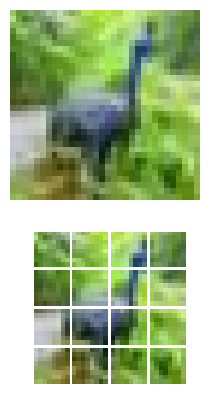

In [20]:
img, ch, img_size, slice_width, slices, slice_flat, batch_size, label = img_data(
    Im_tr_loader, 2)
img_plot(img, slice_width)

### Build the VIT Model : Embedding &rarr; Transformer Encoder &rarr; MLP_Head

In [21]:
class ImageEmbedding(nn.Module):

    def __init__(self, slice_input_size, slice_embed_size, img_slices, dropout_ratio=0.2):
        super().__init__()

        self.img_to_embed = nn.Linear(slice_input_size, slice_embed_size)
        self.cls_to_embed = nn.Parameter(torch.rand(1, slice_embed_size))
        self.pos_to_embed = nn.Parameter(
            torch.rand(1, img_slices + 1, slice_embed_size))

        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, flattened_imgs):
        # the input is a batch of images each has been sliced to patches and each slice
        # has been flattened. i.e. the shape of the input is:
        # [no. of images ,no. of slices per image, size of the flattened image slice]
        #
        img_embedding = self.img_to_embed(flattened_imgs)

        cls_embedding = self.cls_to_embed.repeat(img_embedding.size(0), 1, 1)
        img_embedding = torch.concat([cls_embedding, img_embedding], dim=1)

        position_embedding = self.pos_to_embed.repeat(
            img_embedding.size(0), 1, 1)

        img_and_pos_embedding = img_embedding + position_embedding
        embedding = self.dropout(img_and_pos_embedding)
        return embedding

In [22]:
_, tr_img_t, _ = next(iter(Im_tr_loader))

slice_embed = slice_flat

embedding_layer = ImageEmbedding(slice_input_size=slice_flat,
                                 slice_embed_size=slice_embed,
                                 img_slices=slices,
                                 dropout_ratio=0.2)

embedding_output = embedding_layer(tr_img_t)

print("Input Shape:  ", tr_img_t.size())
print("Output Shape: ", embedding_output.size())
# print(embedding_output)

summary(model=embedding_layer,
        input_size=tr_img_t.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:   torch.Size([16, 16, 192])
Output Shape:  torch.Size([16, 17, 192])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ImageEmbedding (ImageEmbedding)          [16, 16, 192]        [16, 17, 192]        3,456                True
├─Linear (img_to_embed)                  [16, 16, 192]        [16, 16, 192]        37,056               True
├─Dropout (dropout)                      [16, 17, 192]        [16, 17, 192]        --                   --
Total params: 40,512
Trainable params: 40,512
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.59
Input size (MB): 0.20
Forward/backward pass size (MB): 0.39
Params size (MB): 0.15
Estimated Total Size (MB): 0.74

In [23]:
class Encoder(nn.Module):

    def __init__(self, size, num_heads, dropout=0.1):
        super().__init__()

        self.norm_attention = nn.LayerNorm(size)
        self.query = nn.Linear(size, size)
        self.key = nn.Linear(size, size)
        self.value = nn.Linear(size, size)
        self.attention = nn.MultiheadAttention(
            embed_dim=size,
            num_heads=num_heads,
            dropout=0.0,
            bias=True,
            batch_first=True)

        self.norm_feed_forward = nn.LayerNorm(size)
        self.feed_forward = nn.Sequential(
            nn.Linear(size, 4 * size),
            nn.Dropout(dropout),
            nn.GELU(),
            nn.Linear(4 * size, size),
            nn.Dropout(dropout))

    def forward(self, input_tensor):
        attn_input = self.norm_attention(input_tensor)
        query = self.query(attn_input)
        key = self.key(attn_input)
        value = self.value(attn_input)
        attn_output, _ = self.attention(query=query, key=key, value=value)

        attn_plus_norm = input_tensor + attn_output

        mlp_input = self.norm_feed_forward(attn_plus_norm)
        output = attn_plus_norm + self.feed_forward(mlp_input)

        return output

In [24]:
encoder_layer = Encoder(size=slice_flat, num_heads=12, dropout=0.1)
encoder_output = encoder_layer(embedding_output)

print("Output Shape: ", encoder_output.size())

summary(model=encoder_layer,
        input_size=embedding_output.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Output Shape:  torch.Size([16, 17, 192])


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Encoder (Encoder)                        [16, 17, 192]        [16, 17, 192]        --                   True
├─LayerNorm (norm_attention)             [16, 17, 192]        [16, 17, 192]        384                  True
├─Linear (query)                         [16, 17, 192]        [16, 17, 192]        37,056               True
├─Linear (key)                           [16, 17, 192]        [16, 17, 192]        37,056               True
├─Linear (value)                         [16, 17, 192]        [16, 17, 192]        37,056               True
├─MultiheadAttention (attention)         --                   [16, 17, 192]        148,224              True
├─LayerNorm (norm_feed_forward)          [16, 17, 192]        [16, 17, 192]        384                  True
├─Sequential (feed_forward)              [16, 17, 192]        [16, 17, 192]        --                   True
│    └─Linear 

In [25]:
class VIT(nn.Module):
    def __init__(self,
                 slice_input_size,
                 slice_embed_size,
                 img_slices,
                 num_classes,
                 num_heads,
                 num_encoders=1,
                 emb_dropout=0.1,
                 enc_dropout=0.1,
                 lr=1e-4, min_lr=4e-5,
                 weight_decay=0.1,
                 epochs=200):
        super().__init__()

        self.embedding = ImageEmbedding(
            slice_input_size=slice_input_size,
            slice_embed_size=slice_embed_size,
            img_slices=img_slices,
            dropout_ratio=emb_dropout)
        
        self.encoders = nn.Sequential(
            *[Encoder(slice_embed_size, num_heads, dropout=enc_dropout) for _ in range(num_encoders)],)
        
        self.mlp_head = nn.Linear(slice_embed_size, num_classes)
        self.sigmoid=nn.Sigmoid()

        self.lr = lr
        self.min_lr = min_lr
        self.weight_decay = weight_decay
        self.epochs = epochs

    def forward(self, flattened_img):
        emb = self.embedding(flattened_img)
        attn = self.encoders(emb)
        output = torch.round(self.sigmoid(self.mlp_head(attn[:, 0, :])))

        return output

In [26]:
slice_embed = slice_flat*4

vit_model = VIT(slice_input_size=slice_flat,
                slice_embed_size=slice_embed,
                img_slices=slices,
                num_classes=1,
                num_heads=12,
                num_encoders=2,
                emb_dropout=0.1,
                enc_dropout=0.1,
                lr=1e-4, min_lr=4e-5,
                weight_decay=0.1,
                epochs=200)

vit_output = vit_model(tr_img_t)

print("Input Shape: ", tr_img_t.size())
print("Output Shape: ", vit_output.size())

summary(model=vit_model,
        input_size=tr_img_t.size(),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Input Shape:  torch.Size([16, 16, 192])
Output Shape:  torch.Size([16, 1])


Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
VIT (VIT)                                          [16, 16, 192]        [16, 1]              --                   True
├─ImageEmbedding (embedding)                       [16, 16, 192]        [16, 17, 768]        13,824               True
│    └─Linear (img_to_embed)                       [16, 16, 192]        [16, 16, 768]        148,224              True
│    └─Dropout (dropout)                           [16, 17, 768]        [16, 17, 768]        --                   --
├─Sequential (encoders)                            [16, 17, 768]        [16, 17, 768]        --                   True
│    └─Encoder (0)                                 [16, 17, 768]        [16, 17, 768]        --                   True
│    │    └─LayerNorm (norm_attention)             [16, 17, 768]        [16, 17, 768]        1,536                True
│    │    └─Linear (query)                   

In [27]:
vit_epochs = 30         # Number of epochs
base_lr = 10e-3         # Base LR
weight_decay = 0.03     # Weight decay for ViT-Base (on ImageNet-21k)

In [28]:
# Betas used for Adam in paper are 0.9 and 0.999, which are the default in PyTorch
vit_optimizer = Adam(vit_model.parameters(), lr=base_lr, weight_decay=weight_decay)
criterion = CrossEntropyLoss() # returns the mean loss for the batch
scheduler = lr_scheduler.LinearLR(vit_optimizer)

In [29]:
vit_model.to(device)

for epoch in range(vit_epochs):

    # Training Loop
    vit_model.train()

    accumulated_tr_loss = 0
    accumulated_tr_accuracy = 0
    accumulated_val_loss = 0
    accumulated_val_accuracy = 0

    tr_loss_history = []
    tr_accuracy_history = []
    val_loss_history = []
    val_accuracy_history = []

    loop = tqdm(enumerate(Im_tr_loader), total=len(Im_tr_loader))
    for batch, (_, inputs, targets) in loop:

        # Put inputs and labels in device cuda
        tr_images = inputs.to(device)
        tr_labels = targets.to(device)

        # Forward Path
        tr_outputs = vit_model(tr_images).squeeze(1)

        loss = criterion(tr_outputs,tr_labels)

        accumulated_tr_loss += loss.item()
        accumulated_tr_accuracy += (tr_labels == tr_outputs).sum().item()/tr_labels.size(0)
        
        avg_tr_loss = accumulated_tr_loss / (batch+1)
        avg_tr_accuracy = 100*accumulated_tr_accuracy / (batch+1)

        # Backward path (Gradient)
        vit_optimizer.zero_grad()
        loss.backward()

        # Optimizer(Adam) Step
        vit_optimizer.step()

        loop.set_description(f"Epoch [{epoch+1}/{vit_epochs}]")
        loop.set_postfix(loss=avg_tr_loss, acc=avg_tr_accuracy)
    
    tr_loss_history.append(avg_tr_loss)
    tr_accuracy_history.append(avg_tr_accuracy)

    scheduler.step()


# Validation Loop
    vit_model.eval()

    with torch.no_grad():

        for batch, (_, inputs, targets) in enumerate(Im_val_loader):

            # Put inputs and labels in device cuda
            val_images = inputs.to(device)
            val_labels = targets.to(device)

            val_outputs = vit_model(val_images).squeeze(1)

            loss = criterion(val_outputs,val_labels)

            accumulated_val_loss += loss.item()
            accumulated_val_accuracy += (val_labels == val_outputs).sum().item()/val_labels.size(0)

            avg_val_loss = accumulated_val_loss / (batch+1)
            avg_val_accuracy = 100*accumulated_val_accuracy / (batch+1)

        val_loss_history.append(avg_val_loss)
        val_accuracy_history.append(avg_val_accuracy)

        print(f'Validation loss: {avg_val_loss:.2f} | Validation accuracy: {avg_val_accuracy:.2f}')
        print("-------------------------------------------------------------------------------")

Epoch [1/30]: 100%|██████████| 6250/6250 [01:17<00:00, 80.38it/s, acc=50, loss=22.2]  


Validation loss: 22.18 | Validation accuracy: 50.00
-------------------------------------------------------------------------------


Epoch [2/30]: 100%|██████████| 6250/6250 [01:23<00:00, 75.03it/s, acc=49.9, loss=22.3]


Validation loss: 22.18 | Validation accuracy: 50.00
-------------------------------------------------------------------------------


Epoch [3/30]: 100%|██████████| 6250/6250 [01:23<00:00, 74.90it/s, acc=50, loss=22.3]  


Validation loss: 22.18 | Validation accuracy: 50.00
-------------------------------------------------------------------------------


Epoch [4/30]: 100%|██████████| 6250/6250 [01:22<00:00, 75.95it/s, acc=49.9, loss=22.3]


Validation loss: 22.18 | Validation accuracy: 50.00
-------------------------------------------------------------------------------


Epoch [5/30]: 100%|██████████| 6250/6250 [01:19<00:00, 78.57it/s, acc=50, loss=22.3]  


Validation loss: 22.18 | Validation accuracy: 50.00
-------------------------------------------------------------------------------


Epoch [6/30]: 100%|██████████| 6250/6250 [01:23<00:00, 75.00it/s, acc=49.9, loss=22.4]


Validation loss: 22.18 | Validation accuracy: 50.00
-------------------------------------------------------------------------------


Epoch [7/30]: 100%|██████████| 6250/6250 [01:25<00:00, 73.16it/s, acc=49.9, loss=22.4]


Validation loss: 22.18 | Validation accuracy: 50.00
-------------------------------------------------------------------------------


Epoch [8/30]: 100%|██████████| 6250/6250 [01:24<00:00, 74.31it/s, acc=50, loss=22.4]  


Validation loss: 22.18 | Validation accuracy: 50.00
-------------------------------------------------------------------------------


Epoch [9/30]: 100%|█████████▉| 6240/6250 [01:28<00:00, 70.44it/s, acc=49.9, loss=22.4]


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(2, 1)

axs[0].plot(range(len(tr_loss_history )), tr_loss_history , label='Train Loss')
axs[1].plot(range(len(tr_accuracy_history)), tr_accuracy_history, label='Validation Loss')
axs[0].plot(range(len(val_loss_history)), val_loss_history, label='Train Accuracy')
axs[1].plot(range(len(val_accuracy_history)), val_accuracy_history, label='Validation Accuracy')
plt.show()